<a href="https://colab.research.google.com/github/nchlpz/DeepLearning/blob/master/Trabajo_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Deep Learning

### 1. Importar librerías
Lo primero que hacemos es importar las librerías que necesitaremos a lo largo del Notebook.


In [0]:
# Librerías generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Clase para transferir archivos con Google Drive
from google.colab import drive

# Clases para hacer la separación entrenamiento/test y para hacer la
# búsqueda de los hiperparámetros
from sklearn.model_selection import train_test_split, GridSearchCV

# Clases específicas para Deep Learning
from keras import applications
from keras import optimizers
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model, Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, MaxPooling2D, Flatten
from keras.utils import plot_model
from tensorflow.python.framework.errors_impl import ResourceExhaustedError

### 2. Preparar datos de entrenamiento

 

In [11]:
# Montamos el Google Drive en el directorio del proyecto y descomprimios el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/DL_UNIMIB2016.zip' >> /dev/null

# Especificamos los paths al directorio que contiene las imagenes y al fichero con las etiquetas
data_path = 'UNIMIB2016/'
imgs_path = data_path + "images/"
labels_path = data_path + "percentage.csv"

# Leemos el fichero CSV con las etiquetas
labels = pd.read_csv(labels_path)

# Creamos las tres particiones de datos: entrenamiento, validación y test
# 70% training, 15% validación  y 15% test
seed = 0
train_data, test_data = train_test_split(labels, test_size=0.3, random_state=seed)
dev_data, test_data = train_test_split(test_data, test_size=0.5, random_state=seed)

# Actualizamos los índices de cada particion
train_data = train_data.reset_index(drop=True)
dev_data = dev_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Preparamos los datos utilizando normalización (rescale)
datagen = ImageDataGenerator(rescale=1./255)

# dimensiones originales de la imagen
img_width = 3264
img_height = 2448  
x_col = 'image_name'     # nombres de las columnas en el fichero CSV
y_col = 'food_pixels'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 3. Modelo sencillo
Este enfoque probará diferentes CNN sencillas y buscará entre ciertos hiperparámetros los que den mejores resultados.

In [0]:
def plot_history(history, name_file=""):
  """
  Realiza un gráfico con el histórico de errores cuadráticos medios en cada epoch
  para la muestra de entrenamiento y la de validación.
  """
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Error cuadrático medio')
  plt.plot(history.epoch, np.array(history.history['loss']),
           label='MSE en entrenamiento')
  plt.plot(history.epoch, np.array(history.history['val_loss']),
           label='MSE en validación')
  plt.legend()
  plt.show()
  #plt.ylim([0, 30])
  if name_file != "":
    plt.savefig(name_file)

In [0]:
def create_model(Capas, Activations, Filtros, Tamanos):
  """
  Crea una red neuronal a partir de las listas con los hiperparámetros dada.
  """

  # Creamos un modelo secuencial, compuesto por una secuencia lineal de capas
  model = Sequential()

  # Se van añadiendo el resto de las capas según los valores de los parámetros
  # que se han pasado a la función
  for i in range(0, len(Capas)):
    if Capas[i] == "Conv":
      if i == 0:
        model.add(Conv2D(Filtros[i], Tamanos[i], activation=Activations[i], 
                         input_shape=(target_width,target_height,3), 
                         kernel_initializer=initializers.random_normal(stddev=0.01)))
      else:
        model.add(Conv2D(Filtros[i], Tamanos[i], activation=Activations[i], 
                         kernel_initializer=initializers.random_normal(stddev=0.01)))
    elif Capas[i] == "Pool":
        model.add(MaxPooling2D(pool_size=(Tamanos[i],Tamanos[i])))
    elif Capas[i] == "Flatten":
        model.add(Flatten())
    elif Capas[i] == "Dense":
        model.add(Dense(Tamanos[i], activation=Activations[i], 
                        kernel_initializer=initializers.random_normal(stddev=0.01)))

  return model


In [0]:
class ModelClass:
  """
  Esta clase es una forma cómoda de poder definir diferentes estructuras de redes
  neuronales a partir de sus hiperparámetros.
  """

  loss = "mse" # Usaremos siempre esta función de pérdida al ser un problema de regresión

  def __init__(self, Capas=["Conv", "Conv", "Pool", "Conv", "Conv", "Pool", "Flatten", "Dense", "Dense"]
               , Activations=["relu", "relu", "", "relu", "relu", "", "", "relu", "relu"]
               , Filtros=[32,32,0,32,32,0,0,0,0]
               , Tamanos=[3,3,4,3,3,4,0,512,1]
               , LearnRate = 1e-5
               , Optimizer="Adam"
               , Batch=4
               , target_width = 400
               , target_height = 400):
    # Los valores por defecto se han encontrado al realizar varias pruebas y resultan en
    # un RMSE de cerca de 2.5 para la muestra de test
    
    self.Capas = Capas
    self.Activations = Activations
    self.Filtros = Filtros
    self.Tamanos = Tamanos
    self.LearnRate = LearnRate
    self.Optimizer = optimizers.adam(lr=LearnRate)
    self.Batch = Batch

    # las imágenes son muy grandes, si las incluimos en el modelo tal cual, necesitaríamos
    # muchísima RAM. Por lo tanto, hay que reducir el tamaño
    self.target_width = target_width
    self.target_height = target_height

  def optim_upd(self,Optimizer):
    if Optimizer == "Adam":
      self.Optimizer = optimizers.adam(lr=self.LearnRate)
    elif Optimizer == "SGD":
      self.Optimizer = optimizers.SGD(lr=self.LearnRate)

La arquitectura base se puede ver claramente en el siguiente gráfico.

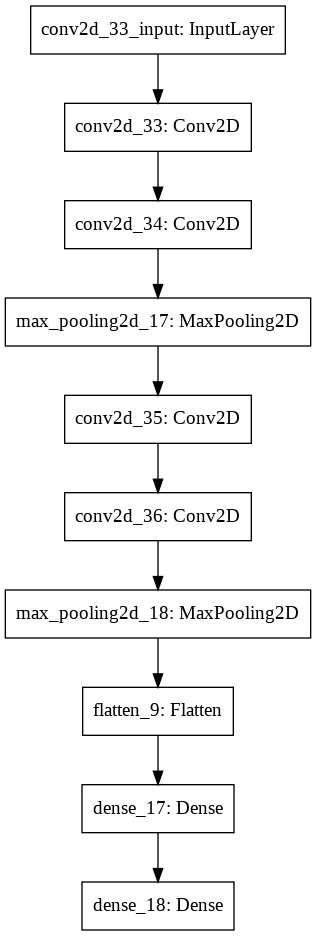

In [42]:
model = create_model(ModelClass().Capas, ModelClass().Activations, ModelClass().Filtros, ModelClass().Tamanos)
plot_model(model, to_file='base_arch.png')

Definiremos diferentes estructuras que probaremos para ver cuáles resultan en un mejor RMSE. Se prueban los siguientes hiperparámetros:


*   Learning rate
*   Tipo de optimizador
*   Tamaño del batch
*   Tamaño de las imágenes transformadas


Se definen, entonces, una serie de redes con los diferentes hiperparámetros.

In [0]:
model_arqs = []

LearnRates = [1e-3, 1e-4, 1e-5]
Optimizers = ["Adam","SGD"]
Batches = [32,16,8,4]   #en orden descendiente para que vaya de más fácil a más difícil 
                        #(simplemente para ver más rápido si ocurre algún fallo)
Sizes = [[int(img_width/i), int(img_height/i)] for i in range(10,4,-1)]

# Arquitectura base
for learnRate in LearnRates:
  for optimizer in Optimizers:
    for size in Sizes:
      for batch in Batches:
        model_arq = ModelClass()
        model_arq.Batch = batch
        model_arq.optim_upd(optimizer)
        model_arq.target_width = size[0]
        model_arq.target_height = size[1]
        model_arqs.append(model_arq)

# Añadiendo un bloque Conv+Conv+Pool a la arquitectura base
for learnRate in LearnRates:
  for optimizer in Optimizers:
    for size in Sizes:
      for batch in Batches:
        model_arq = ModelClass()

        model_arq.Capas=["Conv", "Conv", "Pool", "Conv", "Conv", "Pool", "Conv", "Conv", "Pool", "Flatten", "Dense", "Dense"]
        model_arq.Activations=["relu", "relu", "", "relu", "relu", "", "", "relu", "relu"]
        model_arq.Filtros=[32,32,0,32,32,0,32,32,0,0,0,0]
        model_arq.Tamanos=[3,3,4,3,3,4,3,3,4,0,512,1]

        model_arq.Batch = batch
        model_arq.optim_upd(optimizer)
        model_arq.target_width = size[0]
        model_arq.target_height = size[1]
        model_arqs.append(model_arq)

# Se creará una estructura que tenga diferente tamaño de filtros en orden descendiente. 
# Se intenta capturar los grandes rasgos al principio y los pequeños detalles al final.
for learnRate in LearnRates:
  for optimizer in Optimizers:
    for size in Sizes:
      for batch in Batches:
        model_arq = ModelClass()
        
        model_arq.Capas=["Conv", "Conv", "Pool", "Conv", "Conv", "Pool", "Conv", "Conv", "Pool", "Flatten", "Dense", "Dense"]
        model_arq.Activations=["relu", "relu", "", "relu", "relu", "", "", "relu", "relu"]
        model_arq.Filtros=[64,64,0,32,32,0,16,16,0,0,0,0]
        model_arq.Tamanos=[3,3,4,3,3,4,3,3,4,0,512,1]

        model_arq.Batch = batch
        model_arq.optim_upd(optimizer)
        model_arq.target_width = size[0]
        model_arq.target_height = size[1]
        model_arqs.append(model_arq)

Entrenar todas las redes neuronales previamente definidas, mostrando a su vez las curvas de entrenamiento y su RMSE en la muestra de test.

In [19]:
# Estas dos listas almacenerán los resultados de cada una de las CNN
histories = []
test_losses = []

max_epochs = 20

for model_arq in model_arqs:
  # Generamos los batches con los datos para las tres particiones
  batch_size = model_arq.Batch
  target_height = model_arq.target_height
  target_width = model_arq.target_width
  train_generator = datagen.flow_from_dataframe(dataframe=train_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True, class_mode="raw",
                                                target_size=(target_width,target_height), batch_size=batch_size)
  dev_generator = datagen.flow_from_dataframe(dataframe=dev_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True,
                                            class_mode="raw", target_size=(target_width,target_height), batch_size=batch_size)
  test_generator = datagen.flow_from_dataframe(dataframe=test_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True,
                                            class_mode="raw", target_size=(target_width,target_height), batch_size=batch_size)
  
  # Creamos el modelo
  model = create_model(model_arq.Capas, model_arq.Activations, model_arq.Filtros, model_arq.Tamanos)
  model.compile(loss=model_arq.loss,
                optimizer=model_arq.Optimizer 
                )
  
  # Imprimimos por pantalla el modelo
  print("Learning rate = " + str(model_arq.LearnRate))
  print("Optimizer = " + str(model_arq.Optimizer))
  print("Batch size = " + str(model_arq.Batch))
  print("Width = " + str(model_arq.target_width) + ", height = " + str(model_arq.target_height))
  model.summary()

  # Entrenamos el modelo con los datos preparados	
  # Si no hay una mejora de 0.1 en 5 epochs consecutivas, se termina el entrenamiento
  es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.1, patience=5)
  try:
    histories.append( model.fit_generator(train_generator,
                        epochs=max_epochs,  # numero de epochs (puede ser grande ya que tenemos EarlyStopping)
                        verbose=2,  # muestra informacion del error al finalizar cada epoch
                        steps_per_epoch=len(train_data)/batch_size,
                        validation_data=dev_generator,
                        validation_steps=len(dev_data)/batch_size,
                        callbacks=[es])
    )
  except ResourceExhaustedError:
    print("¡¡¡ Not enough available resources !!!")
    print(" Next iteration...")
    continue

  # Por último, podemos evaluar el modelo en el conjunto de test y mostrar la 
  # curva de entrenamiento
  test_losses.append(model.evaluate_generator(test_generator,
                                        steps=len(test_data)/batch_size,
                                        verbose=1)
  )

  print("test_mse: " + str(test_losses[len(test_losses)-1]))
  print("test_rmse: " + str(np.sqrt(test_losses[len(test_losses)-1])))
  
  # Dibujamos la curva de entrenamiento para la muestra de entrenamiento y la de validación
  plot_history(histories[len(histories)-1], name_file="LR"+str(model_arq.LearnRate)
            +"_OPT"+str(model_arq.Optimizer)[len("keras.optimizers.")+1:str(model_arq.Optimizer).find(" ")]
            +"_BASZ"+str(model_arq.Batch)
            +"_WD"+str(model_arq.Batch)+".jpg")

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.
Learning rate = 1e-05
Optimizer = <keras.optimizers.Adam object at 0x7f0a4c3e8358>
Batch size = 4
Width = 326, height = 244
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 324, 242, 32)      896       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 322, 240, 32)      9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 80, 60, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 78, 58, 32)        9248      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 76, 56, 32)        9248      
_________________

TypeError: ignored

## 4. Modelo con transfer learning
En lugar de crear una CNN y entrenarla desde cero, vamos a probar diferentes modelos pre-entrenados con ImageNet.

Al modelo pre-entrenado, le añadimos unas capas final para poder resolver nuestro problema de regresión. Primero no vamos a modificar los pesos originales de la red pre-entrenada con ImageNet. En un segundo paso, sí que los vamos a modificar, ya que el número de imágenes es elevado y sería posible hacer un fine-tuning.






In [0]:

#### añadir con los diferentes modelos y luego cambiar trainable=True ###

# Cargamos el modelo VGG16 pre-entrenado con ImageNet
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(target_width,target_height,3))

# En este ejemplo vamos a ajustar los parámetros de las nuevas capas del modelo,
# dejando fijos los parámetros del resto de capa (es decir, que no se actualicen durante el entrenamiento)
for layer in base_model.layers:
    layer.trainable = False   # por defecto, el valor de trainable es True

# Añadimos nuevas capas al final para adaptar el modelo a nuestro problema
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
# Añadimos una última capa con una neurona, ya que es un problema de regresión
predictions = Dense(1, activation='relu')(x) 

# Creamos el modelo final y lo compilamos
model = Model(inputs=[base_model.input], outputs=[predictions])
model.summary()   # representación en modo texto del modelo

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0   

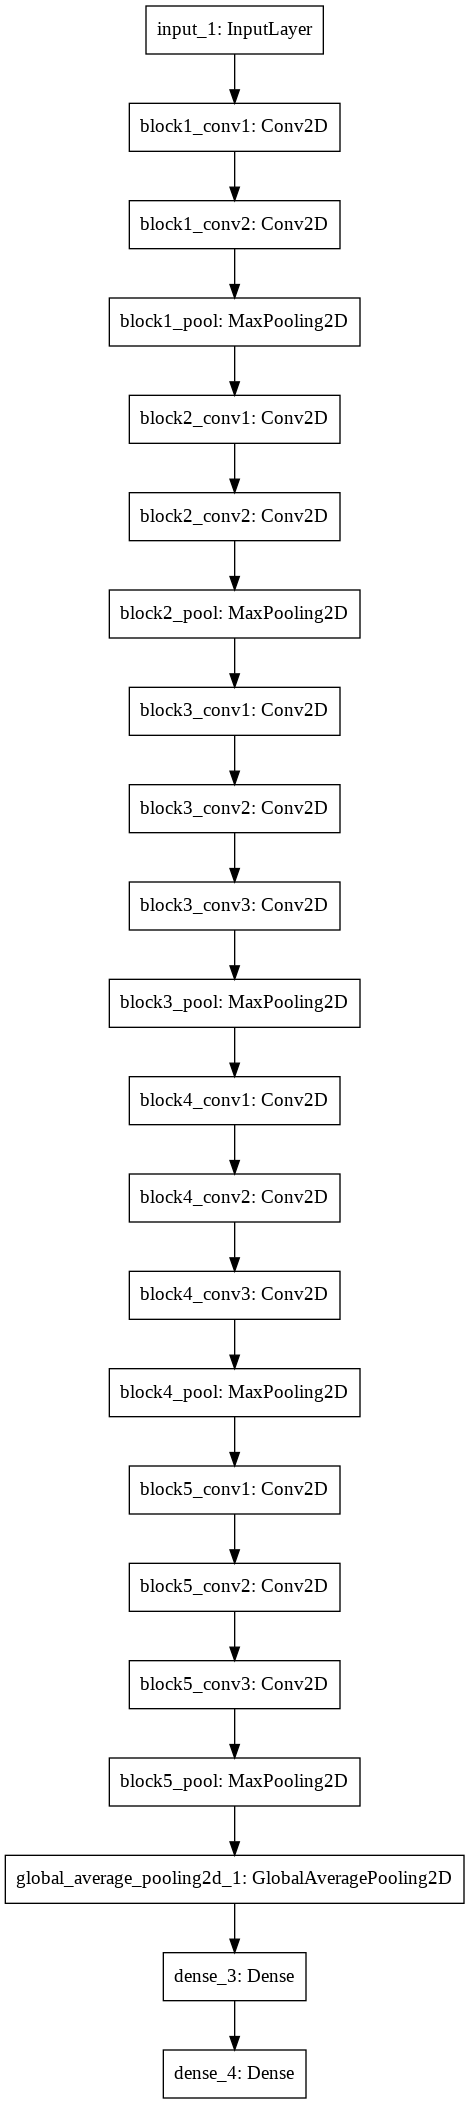

In [0]:
plot_model(model, to_file='model2.png')

In [0]:
model.compile(loss='mse',     # mean-squared error
              optimizer=optimizers.adam(lr=1e-5)  # optimizador Adam, learning rate (lr)
              )

# Entrenamos el modelo con los datos preparados en el punto 2
history = model.fit_generator(train_generator,
                    epochs=15,  # numero de epochs
                    verbose=2,  # muestra informacion del error al finalizar cada epoch
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=dev_generator,
                    validation_steps=len(dev_data)/batch_size)

# Por último, podemos evaluar el modelo en el conjunto de test
print()
test_loss = model.evaluate_generator(test_generator,
                                      steps=len(test_data)/batch_size,
                                      verbose=1)
print("test_mse: " + str(test_loss))
print("test_rmse: " + str(np.sqrt(test_loss)))

Epoch 1/15
 - 11s - loss: 177.0429 - val_loss: 153.0401
Epoch 2/15
 - 10s - loss: 110.5043 - val_loss: 97.0368
Epoch 3/15
 - 10s - loss: 67.9214 - val_loss: 63.1302
Epoch 4/15
 - 10s - loss: 42.7548 - val_loss: 43.4753
Epoch 5/15
 - 10s - loss: 29.1698 - val_loss: 33.4112
Epoch 6/15
 - 10s - loss: 22.9681 - val_loss: 28.8558
Epoch 7/15
 - 10s - loss: 20.4002 - val_loss: 26.9351
Epoch 8/15
 - 10s - loss: 19.3720 - val_loss: 25.9821
Epoch 9/15
 - 10s - loss: 18.9125 - val_loss: 25.4731
Epoch 10/15
 - 10s - loss: 18.5906 - val_loss: 25.0629
Epoch 11/15
 - 10s - loss: 18.3192 - val_loss: 24.7233
Epoch 12/15
 - 10s - loss: 18.0719 - val_loss: 24.3605
Epoch 13/15
 - 10s - loss: 17.8287 - val_loss: 24.0717
Epoch 14/15
 - 10s - loss: 17.7500 - val_loss: 23.6805
Epoch 15/15
 - 10s - loss: 17.2995 - val_loss: 23.3254

39/38 [==============================] - 2s 54ms/step
test_mse: 17.67667067127843
test_rmse: 4.204363289640708


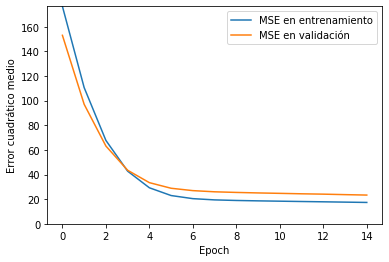

In [0]:
plot_history(history)

## 5. Data augmentation y modelo sencillo

In [0]:
# Generamos los batches con los datos para las tres particiones
datagen = ImageDataGenerator(rescale=1./255, 
                            rotation_range=20,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            horizontal_flip=True)

batch_size = 4              # tamaño del batch
train_generator = datagen.flow_from_dataframe(dataframe=train_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True, class_mode="raw",
                                              target_size=(target_width,target_height), batch_size=batch_size)
dev_generator = datagen.flow_from_dataframe(dataframe=dev_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True,
                                          class_mode="raw", target_size=(target_width,target_height), batch_size=batch_size)
test_generator = datagen.flow_from_dataframe(dataframe=test_data, directory=imgs_path, x_col=x_col, y_col=y_col, has_ext=True,
                                           class_mode="raw", target_size=(target_width,target_height), batch_size=batch_size)

Found 718 validated image filenames.
Found 154 validated image filenames.
Found 155 validated image filenames.


In [0]:
# Creamos un modelo secuencial, compuesto por una secuencia lineal de capas
model = Sequential()

# Añadimos dos capas convolucionales de 32 filtros (dimensiones 3x3), con ReLU como función de activación
model.add(Conv2D(32, 3, activation='relu', input_shape=(target_width,target_height,3)))
model.add(Conv2D(32, 3, activation='relu'))
# Añadimos una capa max-pooling con tamaño de ventana 4
model.add(MaxPooling2D(pool_size=(4,4)))

# Añadimos dos capas convolucionales de 32 filtros (dimensiones 3x3), con ReLU como función de activación
model.add(Conv2D(32, 3, activation='relu'))
model.add(Conv2D(32, 3, activation='relu'))
# Añadimos una capa max-pooling con tamaño de ventana 4
model.add(MaxPooling2D(pool_size=(4,4)))

# Flatten permite transformar el volumen de entrada en un vector
model.add(Flatten())
# Añadimos una capa completamente conectada con 512 neuronas, con ReLU como función de activación 
model.add(Dense(512, activation='relu'))
# Añadimos una última capa completamente conectada con 10 neuronas (número de clases) para obtener la salida de la red,
# utilizando para ello la función Softmax
model.add(Dense(1, activation='relu'))

# Imprimimos la representacion en modo texto del modelo 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 398, 398, 32)      896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 396, 396, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 95, 95, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16928)            

In [0]:
model.compile(loss='mse',     # mean-squared error
              optimizer=optimizers.adam(lr=1e-5)  # optimizador Adam, learning rate (lr)
              )

# Entrenamos el modelo con los datos preparados en el punto 2
history = model.fit_generator(train_generator,
                    epochs=30,  # numero de epochs
                    verbose=2,  # muestra informacion del error al finalizar cada epoch
                    steps_per_epoch=len(train_data)/batch_size,
                    validation_data=dev_generator,
                    validation_steps=len(dev_data)/batch_size)

# Por último, podemos evaluar el modelo en el conjunto de test
print()
test_loss = model.evaluate_generator(test_generator,
                                      steps=len(test_data)/batch_size,
                                      verbose=1)
print("test_mse: " + str(test_loss))
print("test_rmse: " + str(np.sqrt(test_loss)))

Epoch 1/30
 - 32s - loss: 71.0994 - val_loss: 30.8515
Epoch 2/30
 - 30s - loss: 23.1013 - val_loss: 31.9017
Epoch 3/30
 - 30s - loss: 22.8254 - val_loss: 31.1289
Epoch 4/30
 - 30s - loss: 22.7519 - val_loss: 31.6674
Epoch 5/30
 - 30s - loss: 23.1630 - val_loss: 29.7668
Epoch 6/30
 - 30s - loss: 22.0145 - val_loss: 30.0956
Epoch 7/30
 - 30s - loss: 22.1039 - val_loss: 29.2363
Epoch 8/30
 - 30s - loss: 22.0961 - val_loss: 29.0899
Epoch 9/30
 - 30s - loss: 21.6194 - val_loss: 28.3741
Epoch 10/30
 - 30s - loss: 21.1766 - val_loss: 28.2312
Epoch 11/30
 - 30s - loss: 21.0706 - val_loss: 27.1806
Epoch 12/30
 - 30s - loss: 20.8388 - val_loss: 26.7509
Epoch 13/30
 - 30s - loss: 20.3321 - val_loss: 26.8723
Epoch 14/30
 - 30s - loss: 19.5152 - val_loss: 26.0399
Epoch 15/30
 - 30s - loss: 19.0365 - val_loss: 25.8417
Epoch 16/30
 - 30s - loss: 18.8244 - val_loss: 26.0694
Epoch 17/30
 - 30s - loss: 18.3325 - val_loss: 25.1235
Epoch 18/30
 - 30s - loss: 18.3355 - val_loss: 23.3649
Epoch 19/30
 - 30s 

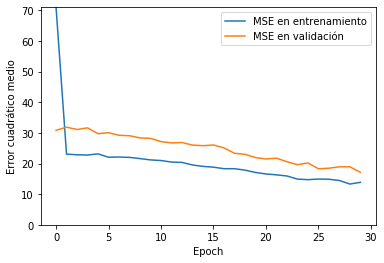

In [0]:
plot_history(history)